In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_01 import *

In [3]:
from fastai.vision import models

# Model

### Unet

Use the Unet that is already available in fastai v1 to begin with.

In [4]:
c = 2
sz = 64

In [5]:
encoder = nn.Sequential(*list(models.resnet34().children())[:-2])

In [6]:
model = models.DynamicUnet(encoder, c, (sz, sz))

In [7]:
model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
models.DynamicUnet??

### Data

Get `DataBunch`, the data object for modeling.  The following lines are from '01_loda_data.ipynb'.

In [8]:
SOURCE = Path('data/')

In [9]:
bs = 4

In [10]:
fnames = get_files(SOURCE/'train'/'train'/'images', extensions=['.png',])
fnames = pre_img_fpaths(fnames)[:200]

xtfms = [ResizeFixed(sz, resample=PIL.Image.BILINEAR), to_byte_tensor, to_float_tensor, Normalize(1/255)]
il = ImageList(fnames, path=Path('data/train/train/images/'), tfms=xtfms)

sd = SplitData.split_by_random(il, val_pct=.1)

ytfms = [ResizeFixed(sz, resample=PIL.Image.NEAREST), to_byte_tensor, to_float_tensor]
ll = label_by_func(sd, img2bmask_fpath, listtype=ImageList, tfms=ytfms)
data = ll.to_databunch(bs, num_workers=4)

In [11]:
x, y = next(iter(data.train_dl))

In [12]:
x.shape, y.shape

(torch.Size([4, 3, 64, 64]), torch.Size([4, 1, 64, 64]))

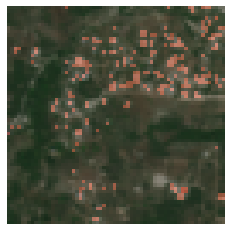

In [13]:
show_sample(x[1], y[1])

### Forward pass through untrained model

Let's pass a mini-batch through the untrained model to make sure that there is no Exception.

In [14]:
pred = model(x)

In [15]:
pred.argmax(1)[1][None,...].dtype

torch.int64

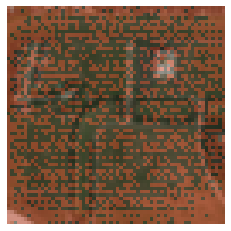

In [27]:
show_sample(x[3], pred.argmax(dim=1)[3][None,...].float())

### Loss function

Flatten out the tensor such that dimension 0 lines up all the pixels in the image/mask, then feed to `nn.CrossEntropyLoss`.

In [28]:
pred.permute(0, 2, 3, 1).reshape(-1, 2).shape

torch.Size([16384, 2])

In [29]:
y.permute(0, 2, 3, 1).reshape(-1).shape

torch.Size([16384])

In [30]:
class FlattenedCE():
    def __init__(self): self.loss = nn.CrossEntropyLoss()
    def __call__(self, inp, targ):
        inp = inp.permute(0, 2, 3, 1).reshape(-1, 2)
        targ = targ.permute(0, 2, 3, 1).reshape(-1).long()
        return self.loss(inp, targ)

In [31]:
loss = FlattenedCE()
loss(pred, y)

tensor(0.8858, grad_fn=<NllLossBackward>)

### Metrics

In [32]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask].float() == targ[mask]).float().mean()

In [33]:
foreground_acc(pred, y, bkg_idx=0, axis=1)

tensor(0.5451)

### Learner

`Learner` and `Callback`s make up what's used for the training and validation of the Unet model on the `DataBunch`.  The various definitions for these are slightly scattered among fastai (part2 2019) notebooks, the final versions are gathered here.

In [271]:
TrainEvalCallback??

In [34]:
AvgStats??

In [23]:
cbfs = [ProgressCallback, partial(AvgStatsCallback, foreground_acc)]

learn = Learner(model, data, loss_func=FlattenedCE(), cb_funcs=cbfs, lr=1e-1)

In [24]:
learn.fit(1, cbs=[LR_Find(), Recorder(), ])

epoch,train_loss,train_foreground_acc,valid_loss,valid_foreground_acc,time
0,0.905587,0.445319,1.049915,0.674048,01:02


In [27]:
learn.cbs

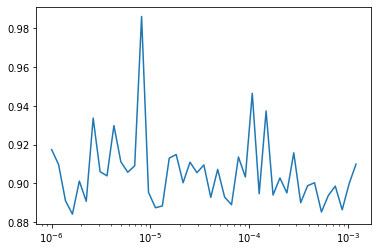

In [25]:
learn.recorder.plot()

In [26]:
learn.fit(2)

epoch,train_loss,train_foreground_acc,valid_loss,valid_foreground_acc,time
0,0.879767,0.459394,0.936773,0.523976,01:01
1,0.843612,0.464635,1.144220,0.452060,01:00


In [27]:
learn.fit(9)

epoch,train_loss,train_foreground_acc,valid_loss,valid_foreground_acc,time
0,0.230978,0.010260,0.226089,0.000000,00:54
1,0.225717,0.015735,0.211651,0.000608,00:53
2,0.223124,0.018857,0.195508,0.001039,00:53
3,0.223133,nan,0.220780,0.000000,01:57
4,0.222931,0.014603,0.190776,0.002870,00:54
5,0.222854,0.018749,0.190353,0.005625,00:53
6,0.220226,0.020049,0.199662,0.004517,00:59
7,0.214062,0.033096,0.193909,0.003005,00:54
8,0.222153,0.030583,0.185586,0.019781,00:55


In [28]:
x, y = next(iter(data.valid_dl))

In [29]:
pred = model(x)

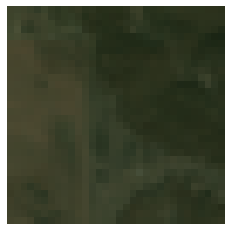

In [34]:
show_sample(x[2], pred.argmax(dim=1)[2][None,...].float())

# -fin

In [7]:
! python notebook2script.py 02_model.ipynb

Converted 02_model.ipynb to xview2comp/nb_02.py
